<a href="https://colab.research.google.com/github/Qvery-mm/Semi-supervised-learning/blob/main/MNIST_Semi_Supervised_learing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-Supervised training a neural network on MNIST with Keras
# Aleksandr Kovalchukov
### JetBrains applicant work
### April 2021


In [ ]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Step 1: Loading dataset

In [ ]:
(ds_train_original, ds_test_original), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Explore dataset

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

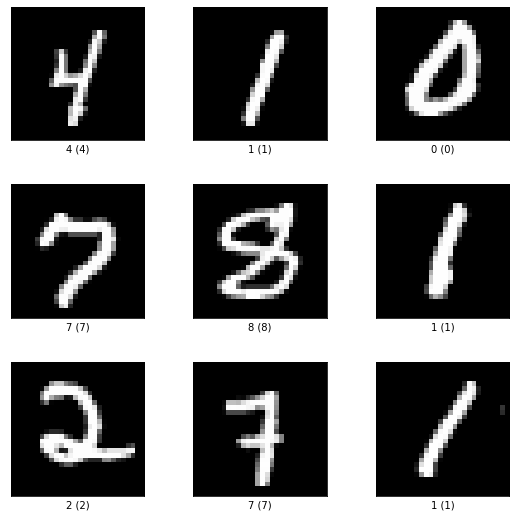

In [ ]:
fig = tfds.show_examples(ds_train_original, ds_info)

In [ ]:
for i in ds_train_original.take(5):
    print('img shape:', i[0].shape, '| label:', i[1])

img shape: (28, 28, 1) | label: tf.Tensor(4, shape=(), dtype=int64)
img shape: (28, 28, 1) | label: tf.Tensor(1, shape=(), dtype=int64)
img shape: (28, 28, 1) | label: tf.Tensor(0, shape=(), dtype=int64)
img shape: (28, 28, 1) | label: tf.Tensor(7, shape=(), dtype=int64)
img shape: (28, 28, 1) | label: tf.Tensor(8, shape=(), dtype=int64)


### It can be seen that labels represented as integers.

### Let's provide `one-hot` representation instead.


In [ ]:
ds_train_one_hot = ds_train_original.map(lambda x, y: (x, tf.one_hot(y, 10)))
ds_test_one_hot = ds_test_original.map(lambda x, y: (x, tf.one_hot(y, 10)))

for i in ds_train_one_hot.take(5):
    print(i[0].shape, i[1])

(28, 28, 1) tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
(28, 28, 1) tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
(28, 28, 1) tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
(28, 28, 1) tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
(28, 28, 1) tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)


### From now, label represented as stochastic 10-dimensional vector

# Step 2: Prepare our training set for learning with different settings




In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
def prepare_dataset(ds_train, num_labeled, unlabeled_rate=0.0, batch_size=128):
    '''Preprocess training set
    It takes a dataset and split it in the desired proportion in order to make some of examples unlabeled.
    
    Args:
    ds_train(tensorflow.python.data.ops.dataset_ops.MapDataset): training set with one-hot labels

    num_labeled(int): desired number of labeled examples in output dataset

    unlabeled_rate(float): 0.00 <= unlabeled_rate <= 100.00 - rate of unlabeled examples in output dataset. 
                           unlabeled_rate == num_unlabeled / num_labeled
    
    Returns:
    (tensorflow.python.data.ops.dataset_ops.MapDataset): dataset with specified number of labeled and unlabeled examples

    '''

    num_examples = ds_info.splits['train'].num_examples

    assert 0.00 <= unlabeled_rate
    assert num_labeled * (1 + unlabeled_rate) <= num_examples
    
    num_unlabeled = int(unlabeled_rate * num_labeled)
    ds_labeled = ds_train_one_hot.take(num_labeled)
    ds_unlabeled = ds_train_one_hot.skip(num_labeled).take(num_unlabeled)
    '''Split dataset on labeled and unlabeled part''' 
    
    print('Number of labeled examples:', len(ds_labeled), 'number of unlabeled:', len(ds_unlabeled))

    ds_unlabeled = ds_unlabeled.map(lambda x, y: (x, tf.convert_to_tensor(np.ones(10, dtype='float32'))))
    '''We won't completely remove label, but we replace one-hot vector on vector of ones

    E.g. labeled example representation (label==4):   tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
         unlabeled example representation:            tf.Tensor([1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(10,), dtype=float32)
    '''

    ds_train = ds_unlabeled.concatenate(ds_labeled).shuffle(len(ds_train)) # combine parts together
    
    ds_train = ds_train.map(
        normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(len(ds_train))
    ds_train = ds_train.batch(batch_size)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
    '''Prepare dataset for feeding into neural network'''

    return ds_train

In [ ]:
ds_train = prepare_dataset(ds_train_one_hot, 200, 0.6)
for i in ds_train.take(10):
  print(i[1])

Number of labeled examples: 200 number of unlabeled: 120
tf.Tensor(
[[1. 1. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 10), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]], shape=(128, 10), dtype=float32)
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1.

### Also preprocess test set

In [ ]:
ds_test = ds_test_one_hot.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# Step 3: Create Loss functions

In [ ]:
_EPSILON = 1e-7

def categorical_crossentropy(target, output, from_logits=False, axis=-1):
    ''' Compute crossentropy loss
    This is default categorical_crossentropy taken from keras/backend.py with minor changes.
    '''
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)

    output = tf.clip_by_value(output, _EPSILON, 1. - _EPSILON)
    
    return -tf.reduce_sum(target * tf.math.log(output), axis)
    

### Following loss provides minimum entropy regularisation

### It measures both labeled and unlabeled examples.

$Loss(a, x, z) = - \log(\sum\limits_{k=0}^{9} z_k a_k(x)) - \lambda \sum\limits_{k=0}^9 g_k(x, z) \log(g_k(x, z))$,

where: $g_k(x, z) = \dfrac{z_k a_k(x)}{\sum_{l=1}^9 z_l a_l(x)}$

$z$ - true label, $a(x)$ - predicted label

$\lambda$ - regularization term


### For more details see [1].


In [ ]:
def categorical_min_entropy(target, output, from_logits=False, axis=-1):
  
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    target.shape.assert_is_compatible_with(output.shape)

    output = tf.clip_by_value(output, _EPSILON, 1. - _EPSILON)

    reg_term = tf.constant(0.02)
    # reg_term = tf.constant(1.0)
    g = target * output / tf.reduce_sum(target * output, axis, keepdims=True)
    g = tf.clip_by_value(g, _EPSILON, 1. - _EPSILON)
    return -tf.math.log(tf.reduce_sum(target * output, axis)) - reg_term * tf.reduce_sum(g * tf.math.log(g), axis)

# Step 4: Create the model

In [ ]:
class Model:
    def __init__(self, loss):
        self.model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28)),
          tf.keras.layers.Dense(128,activation='relu'),
          tf.keras.layers.Dense(10, activation='softmax')
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss=loss,
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )

    def fit(self, dataset_train, n_epochs=6):
        self.model.fit(
        dataset_train,
        epochs=n_epochs
        )
    
    def evaluate(self, datasets_test):
        return self.model.evaluate(datasets_test)
    
    def predict(self, dataset_test):
        return self.model.predict(dataset_test) 

# Step 5: Learning with crossentropy loss

In [ ]:
n_examples = len(ds_train_one_hot)
ds_train = prepare_dataset(ds_test_one_hot, n_examples, 0.0) # use all labeled dataset
model = Model(categorical_crossentropy)
model.fit(ds_train)
print('\nTest set accuracy:', model.evaluate(ds_test)[1])

Number of labeled examples: 60000 number of unlabeled: 0
Epoch 1/6
469/469 [==============================] - 8s 3ms/step - loss: 0.5986 - categorical_accuracy: 0.8372
Epoch 2/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1714 - categorical_accuracy: 0.9525
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1230 - categorical_accuracy: 0.9643
Epoch 4/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0911 - categorical_accuracy: 0.9728
Epoch 5/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0737 - categorical_accuracy: 0.9785
Epoch 6/6
79/79 [==============================] - 1s 14ms/step - loss: 0.0890 - categorical_accuracy: 0.9717

Test set accuracy: 0.9717000126838684


In [ ]:
ans = model.predict(ds_test)
ans = tf.argmax(ans, axis=1)
true_labels = [i[1] for i in ds_test_original]
pd.DataFrame(tf.math.confusion_matrix(true_labels, ans).numpy())


,0,1,2,3,4,5,6,7,8,9
0,972,0,1,1,1,0,1,1,2,1
1,0,1118,3,1,0,1,4,1,7,0
2,6,3,1001,0,4,0,2,8,8,0
3,1,0,5,983,0,3,0,8,5,5
4,1,0,3,1,957,0,4,2,1,13
5,4,1,0,14,2,852,5,3,6,5
6,6,2,1,1,6,5,931,0,6,0
7,1,4,8,4,1,0,0,1002,0,8
8,9,1,2,8,7,3,4,8,928,4
9,5,3,1,11,7,1,0,8,0,973


In [ ]:
df = tfds.as_dataframe(ds_test_original.take(10), ds_info)
df['predicted'] = ans[:10]
df


image  label  predicted
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      2          2
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      0          0
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      4          4
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      8          8
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      7          7
5  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      6          6
6  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      0          0
7  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      6          6
8  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      3          3
9  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      1          1

# Step 6: Learning with min entropy loss and various labeled proportions

In [ ]:
semi_history = []
for percent in np.linspace(-2, 2, 20):

  n_labeled = 200

  unlabeled_rate = 10**percent # unlabeled_rate from 0.01 to 100
  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, unlabeled_rate)
  model = Model(categorical_min_entropy)
  model.fit(ds_train)
  acc = model.evaluate(ds_test)
  semi_history.append((int(n_labeled * 10**percent), acc[1]))

Number of labeled examples: 200 number of unlabeled: 2
Epoch 1/6
2/2 [==============================] - 1s 8ms/step - loss: 2.3199 - categorical_accuracy: 0.1341
Epoch 2/6
2/2 [==============================] - 0s 13ms/step - loss: 2.0197 - categorical_accuracy: 0.3864
Epoch 3/6
2/2 [==============================] - 0s 7ms/step - loss: 1.7909 - categorical_accuracy: 0.5349
Epoch 4/6
2/2 [==============================] - 0s 6ms/step - loss: 1.5603 - categorical_accuracy: 0.6721
Epoch 5/6
2/2 [==============================] - 0s 7ms/step - loss: 1.3705 - categorical_accuracy: 0.7273
Epoch 6/6
79/79 [==============================] - 0s 2ms/step - loss: 1.3832 - categorical_accuracy: 0.6644
Number of labeled examples: 200 number of unlabeled: 3
Epoch 1/6
2/2 [==============================] - 1s 8ms/step - loss: 2.2410 - categorical_accuracy: 0.1834
Epoch 2/6
2/2 [==============================] - 0s 6ms/step - loss: 1.9656 - categorical_accuracy: 0.4107
Epoch 3/6
2/2 [================

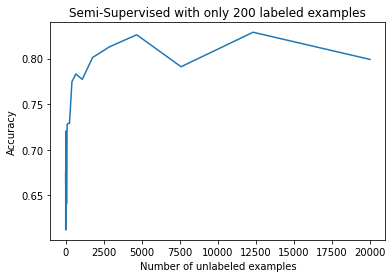

In [ ]:
semi_history = np.array(semi_history)
plt.plot(semi_history[:, 0], semi_history[:,1])
plt.xlabel('Number of unlabeled examples')
plt.ylabel('Accuracy')
plt.title('Semi-Supervised with only 200 labeled examples')
plt.show()

### So maximum accuracy is reached at unlabeled ratio of 14 : 1

### Let's discover further.

In [ ]:
mixed_history_12 = []
ratio = 14.0
max_labeled_number = int(60000 / (ratio + 1))
for n_labeled in range(200, max_labeled_number, 200):

  
  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 14.0)
  model = Model(categorical_min_entropy)
  model.fit(ds_train)
  acc_mix_labeled = model.evaluate(ds_test)

  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 0.0)
  model = Model(categorical_min_entropy)
  model.fit(ds_train)
  acc_labeled_min_entropy = model.evaluate(ds_test)

  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 0.0)
  model = Model(categorical_crossentropy)
  model.fit(ds_train)
  acc_labeled_crossentropy = model.evaluate(ds_test)

  mixed_history_12.append((n_labeled, acc_mix_labeled[1], acc_labeled_min_entropy[1], acc_labeled_crossentropy[1]))

Number of labeled examples: 200 number of unlabeled: 2800
Epoch 1/6
24/24 [==============================] - 1s 3ms/step - loss: 0.1905 - categorical_accuracy: 0.0780
Epoch 2/6
24/24 [==============================] - 0s 3ms/step - loss: 0.1125 - categorical_accuracy: 0.1204
Epoch 3/6
24/24 [==============================] - 0s 3ms/step - loss: 0.0670 - categorical_accuracy: 0.1663
Epoch 4/6
24/24 [==============================] - 0s 3ms/step - loss: 0.0435 - categorical_accuracy: 0.1604
Epoch 5/6
24/24 [==============================] - 0s 3ms/step - loss: 0.0297 - categorical_accuracy: 0.1681
Epoch 6/6
79/79 [==============================] - 0s 2ms/step - loss: 0.6003 - categorical_accuracy: 0.8116
Number of labeled examples: 200 number of unlabeled: 0
Epoch 1/6
2/2 [==============================] - 0s 8ms/step - loss: 2.3806 - categorical_accuracy: 0.1094
Epoch 2/6
2/2 [==============================] - 0s 7ms/step - loss: 2.0449 - categorical_accuracy: 0.3494
Epoch 3/6
2/2 [====

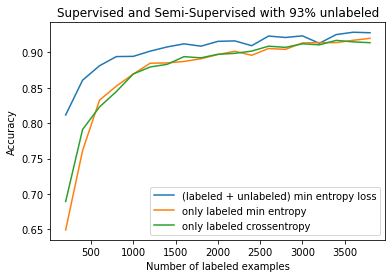

In [ ]:
mixed_history_12 = np.array(mixed_history_12)
plt.plot(mixed_history_12[:, 0], mixed_history_12[:,1], label='(labeled + unlabeled) min entropy loss')
plt.plot(mixed_history_12[:, 0], mixed_history_12[:,2], label='only labeled min entropy')
plt.plot(mixed_history_12[:, 0], mixed_history_12[:,3], label='only labeled crossentropy')
plt.xlabel('Number of labeled examples')
plt.ylabel('Accuracy')
plt.title('Supervised and Semi-Supervised with 93% unlabeled')
plt.legend()
plt.show()

In [ ]:
mixed_history_1 = []
for n_labeled in range(200, 30000 + 1, 1000):

  
  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 1.0)
  model = Model(categorical_min_entropy)
  model.fit(ds_train)
  acc_mix_labeled = model.evaluate(ds_test)

  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 0.0)
  model = Model(categorical_min_entropy)
  model.fit(ds_train)
  acc_labeled_min_entropy = model.evaluate(ds_test)

  ds_train = prepare_dataset(ds_train_one_hot, n_labeled, 0.0)
  model = Model(categorical_crossentropy)
  model.fit(ds_train)
  acc_labeled_crossentropy = model.evaluate(ds_test)

  mixed_history_1.append((n_labeled, acc_mix_labeled[1], acc_labeled_min_entropy[1], acc_labeled_crossentropy[1]))

Number of labeled examples: 200 number of unlabeled: 200
Epoch 1/6
4/4 [==============================] - 1s 4ms/step - loss: 1.2091 - categorical_accuracy: 0.2080
Epoch 2/6
4/4 [==============================] - 0s 4ms/step - loss: 0.9279 - categorical_accuracy: 0.2914
Epoch 3/6
4/4 [==============================] - 0s 5ms/step - loss: 0.7700 - categorical_accuracy: 0.3067
Epoch 4/6
4/4 [==============================] - 0s 6ms/step - loss: 0.6510 - categorical_accuracy: 0.3769
Epoch 5/6
4/4 [==============================] - 0s 4ms/step - loss: 0.5503 - categorical_accuracy: 0.4452
Epoch 6/6
79/79 [==============================] - 0s 2ms/step - loss: 1.0511 - categorical_accuracy: 0.7283
Number of labeled examples: 200 number of unlabeled: 0
Epoch 1/6
2/2 [==============================] - 0s 8ms/step - loss: 2.3267 - categorical_accuracy: 0.1139
Epoch 2/6
2/2 [==============================] - 0s 8ms/step - loss: 2.0193 - categorical_accuracy: 0.3905
Epoch 3/6
2/2 [===============

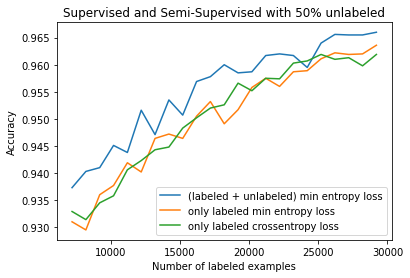

In [ ]:
mixed_history_1 = np.array(mixed_history_1)
plt.plot(mixed_history_1[7:, 0], mixed_history_1[7:,1], label='(labeled + unlabeled) min entropy loss')
plt.plot(mixed_history_1[7:, 0], mixed_history_1[7:,2], label='only labeled min entropy loss')
plt.plot(mixed_history_1[7:, 0], mixed_history_1[7:,3], label='only labeled crossentropy loss')
plt.xlabel('Number of labeled examples')
plt.ylabel('Accuracy')
plt.title('Supervised and Semi-Supervised with 50% unlabeled')
plt.legend()
plt.show()

# Conclusion

Semi-supervised learning actually able to improve model perfomance, especially in the context of a lack of labeled examples.

Experiment shows that on fully labeled dataset min entropy loss does not differ significanly from classic crossentropy. 

But in presence of unlabeled examples it reduce classification error up to 10% depending on the number of labeled examples and the proportion of unlabeled ones.



# References

1.  Grandvalet, Y., & Bengio, Y. (2005, December). Semi-supervised learning by entropy minimization. In CAP (pp. 281-296).

2.  LeCun, Y., Cortes, C., & Burges, C. J. (2010). MNIST handwritten digit database.


